In [0]:
# Import the required libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import mlflow
import mlflow.keras
import mlflow.tensorflow


In [0]:
# Load and preprocess data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
 
cal_housing = fetch_california_housing()
 
# Split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2)

In [0]:
# Scale features
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
# Create the neural network
def create_model():
  model = Sequential()
  model.add(Dense(20, input_dim=8, activation="relu"))
  model.add(Dense(20, activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

In [0]:
# Compile the model
model = create_model()
 
model.compile(loss="mse",
              optimizer="Adam",
              metrics=["mse"])

In [0]:
# Create callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
 
# In the following lines, replace <username> with your username.
experiment_log_dir = "/dbfs/<username>/tb"
checkpoint_path = "/dbfs/<username>/keras_checkpoint_weights.ckpt"
 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=3)
 
history = model.fit(X_train, y_train, validation_split=.2, epochs=35, callbacks=[tensorboard_callback, model_checkpoint, early_stopping])

Epoch 1/35
394/413 [===========================>..] - ETA: 0s - loss: 1.1940 - mse: 1.1940
Epoch 00001: val_loss improved from inf to 0.60959, saving model to /dbfs/<username>/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/<username>/keras_checkpoint_weights.ckpt/assets
413/413 [==============================] - 3s 5ms/step - loss: 1.1696 - mse: 1.1696 - val_loss: 0.6096 - val_mse: 0.6096
Epoch 2/35
400/413 [============================>.] - ETA: 0s - loss: 0.5173 - mse: 0.5173
Epoch 00002: val_loss improved from 0.60959 to 0.45891, saving model to /dbfs/<username>/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/<username>/keras_checkpoint_weights.ckpt/assets
413/413 [==============================] - 2s 5ms/step - loss: 0.5156 - mse: 0.5156 - val_loss: 0.4589 - val_mse: 0.4589
Epoch 3/35
388/413 [===========================>..] - ETA: 0s - loss: 0.4399 - mse: 0.4399
Epoch 00003: val_loss improved from 0.45891 to 0.40728, saving model to /

When you start TensorBoard this way, it continues to run until you detach the notebook from the cluster.

Note: to clear the TensorBoard between runs, use this command:

dbutils.fs.rm(experiment_log_dir.replace("/dbfs",""), recurse=True)

%load_ext tensorboard

%tensorboard --logdir $experiment_log_dir

The tensorboard extension is already loaded. To reload it, use:

  %reload_ext tensorboard
  
Launching TensorBoard...

Reusing TensorBoard on port 6006 (pid 3391), started 0:04:21 ago. (Use '!kill 3391' to kill it.)

Note: TensorBoard is only available when this notebook remains attached to the cluster.

The command in the following cell displays a link that, when clicked, opens TensorBoard in a new tab.

When you start TensorBoard this way, it continues to run until you either stop it with

dbutils.tensorboard.stop()

or you shut down the cluster.

In [0]:
#dbutils.tensorboard.start(experiment_log_dir)

In [0]:
model.evaluate(X_test, y_test)

129/129 [==============================] - 19s 148ms/step - loss: 0.2803 - mse: 0.2803
Out[10]: [0.28029805421829224, 0.28029805421829224]

Hyperopt is a Python library for hyperparameter tuning. Databricks Runtime for Machine Learning includes an optimized and enhanced version of Hyperopt, including automated MLflow tracking. For more information about using Hyperopt, see the Hyperopt documentation.

In [0]:
# Create neural network model using variables for number of nodes in hidden layers
def create_model(n):
  model = Sequential()
  model.add(Dense(int(n["dense_l1"]), input_dim=8, activation="relu"))
  model.add(Dense(int(n["dense_l2"]), activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

In [0]:
# Create Hyperopt objective function
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials
 
def runNN(n):
  # Import tensorflow 
  import tensorflow as tf
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_model(n)
 
  # Select optimizer
  optimizer_call = getattr(tf.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n["learning_rate"])
 
  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
 
  history = model.fit(X_train, y_train, validation_split=.2, epochs=10, verbose=2)
 
  # Evaluate the model
  score = model.evaluate(X_test, y_test, verbose=0)
  obj_metric = score[0]  
  return {"loss": obj_metric, "status": STATUS_OK}

In [0]:
# Define Hyperopt search space
space = {
  "dense_l1": hp.quniform("dense_l1", 10, 30, 1),
  "dense_l2": hp.quniform("dense_l2", 10, 30, 1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

The 'SparkTrials' object tells 'fmin()'' to distribute the tuning job across a Spark cluster. When you create the 'SparkTrials' object, you can use the 'parallelism' argument to set the maximum number of trials to evaluate concurently. The default setting is the number of Spark executors available.

A higher number lets you scale-out testing of more hyperparameter settings. Because Hyperopt proposes new trials based on past results, there is a trade-off between parallelism and adaptivity. For a fixed 'max_evals', greater parallelism speeds up calculations, but lower parallelism may lead to better results since each iteration has access to more past results.

#### If you do not specify a parallelism argument, the default is the number of available Spark executors 

spark_trials = SparkTrials()

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or the current total of Spark task slots (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.

#### Perform hyperparameter tuning

Put the 'fmin()'' call inside an MLflow run to save results to MLflow. MLflow tracks the parameters and performance metrics of each run.

After running the following cell, you can view the results in MLflow. Click Experiment at the upper right to display the Experiment Runs sidebar. Click the icon at the far right next to Experiment Runs to display the MLflow Runs Table.

For more information about using MLflow to analyze runs, see (AWS|Azure|GCP).

In [0]:
spark_trials = SparkTrials()

with mlflow.start_run():
  best_hyperparam = fmin(fn=runNN, 
                         space=space, 
                         algo=tpe.suggest, 
                         max_evals=30, 
                         trials=spark_trials)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]/databricks/spark/python/pyspark/rdd.py:980: FutureWarning: Deprecated in 3.1, Use pyspark.InheritableThread with the pinned thread mode enabled.

# Part 3. Use the best set of hyperparameters to build a final model

In [0]:
import hyperopt
 
print(hyperopt.space_eval(space, best_hyperparam))

{'dense_l1': 27.0, 'dense_l2': 22.0, 'learning_rate': 0.008727327774527574, 'optimizer': 'Adam'}


In [0]:
first_layer = hyperopt.space_eval(space, best_hyperparam)["dense_l1"]
second_layer = hyperopt.space_eval(space, best_hyperparam)["dense_l2"]
learning_rate = hyperopt.space_eval(space, best_hyperparam)["learning_rate"]
optimizer = hyperopt.space_eval(space, best_hyperparam)["optimizer"]

In [0]:
# Get optimizer and update with learning_rate value
optimizer_call = getattr(tf.keras.optimizers, optimizer)
optimizer = optimizer_call(learning_rate=learning_rate)

In [0]:
def create_new_model():
  model = Sequential()
  model.add(Dense(first_layer, input_dim=8, activation="relu"))
  model.add(Dense(second_layer, activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

In [0]:
new_model = create_new_model()
  
new_model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])

When 'autolog()'' is active, MLflow does not automatically end a run. We need to end the run that was started in Cmd 30 before starting and autologging a new run.

For more information, see https://www.mlflow.org/docs/latest/tracking.html#automatic-logging.

In [0]:
mlflow.end_run()

Epoch 1/35
516/516 [==============================] - 2s 2ms/step - loss: 0.5529 - mse: 0.5529
Epoch 2/35
516/516 [==============================] - 1s 2ms/step - loss: 0.3828 - mse: 0.3828
Epoch 3/35
516/516 [==============================] - 1s 2ms/step - loss: 0.3575 - mse: 0.3575
Epoch 4/35
516/516 [==============================] - 1s 2ms/step - loss: 0.3480 - mse: 0.3480
Epoch 5/35
516/516 [==============================] - 1s 2ms/step - loss: 0.3333 - mse: 0.3333
Epoch 6/35
516/516 [==============================] - 1s 2ms/step - loss: 0.3469 - mse: 0.3469
Epoch 7/35
516/516 [==============================] - 1s 2ms/step - loss: 0.3287 - mse: 0.3287
Epoch 8/35
413/516 [=======================>......] - ETA: 0s - loss: 0.3157 - mse: 0.3157

*** WARNING: max output size exceeded, skipping output. ***

516/516 [==============================] - 1s 2ms/step - loss: 0.2885 - mse: 0.2885
Epoch 20/35
516/516 [=============================

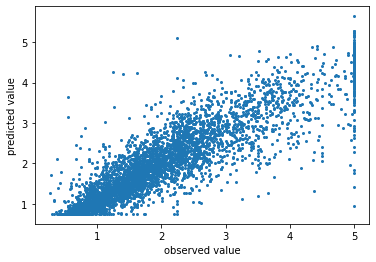

In [0]:
import matplotlib.pyplot as plt
 
mlflow.tensorflow.autolog()
 
with mlflow.start_run() as run:
  
  history = new_model.fit(X_train, y_train, epochs=35, callbacks=[early_stopping])
  
  # Save the run information to register the model later
  kerasURI = run.info.artifact_uri
  
  # Evaluate model on test dataset and log result
  mlflow.log_param("eval_result", new_model.evaluate(X_test, y_test)[0])
  
  # Plot predicted vs known values for a quick visual check of the model and log the plot as an artifact
  keras_pred = new_model.predict(X_test)
  plt.plot(y_test, keras_pred, "o", markersize=2)
  plt.xlabel("observed value")
  plt.ylabel("predicted value")
  plt.savefig("kplot.png")
  mlflow.log_artifact("kplot.png")

# Part 4. Register the model in MLflow and use the model to make predictions

To learn more about the Model Registry, see (AWS|Azure|GCP).

In [0]:
import time
 
model_name = "cal_housing_keras"
model_uri = kerasURI+"/model"
new_model_version = mlflow.register_model(model_uri, model_name)
 
# Registering the model takes a few seconds, so add a delay before continuing with the next cell
time.sleep(5)

---------------------------------------------------------------------------
RestException                             Traceback (most recent call last)
<command-3715122328084921> in <module>
      3 model_name = "cal_housing_keras"
      4 model_uri = kerasURI+"/model"
----> 5 new_model_version = mlflow.register_model(model_uri, model_name)
      6 
      7 # Registering the model takes a few seconds, so add a delay before continuing with the next cell

/databricks/python/lib/python3.8/site-packages/mlflow/tracking/_model_registry/fluent.py in register_model(model_uri, name, await_registration_for)
     65             )
     66         else:
---> 67             raise e
     68 
     69     if RunsArtifactRepository.is_runs_uri(model_uri):

/databricks/python/lib/python3.8/site-packages/mlflow/tracking/_model_registry/fluent.py in register_model(model_uri, name, await_registration_for)
     56     client = MlflowClient()
     57     try:
---> 58         create_model_response = client.cr

## Load the model for inference and make predictions

In [0]:
keras_model = mlflow.keras.load_model(f"models:/{model_name}/{new_model_version.version}")
 
keras_pred = keras_model.predict(X_test)
keras_pred


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-3715122328084923> in <module>
----> 1 keras_model = mlflow.keras.load_model(f"models:/{model_name}/{new_model_version.version}")
      2 
      3 keras_pred = keras_model.predict(X_test)
      4 keras_pred

NameError: name 'new_model_version' is not defined

Out[48]: array([[1.5230944],
       [0.8047272],
       [1.7866669],
       ...,
       [1.3924406],
       [1.7938632],
       [0.8235668]], dtype=float32)

## Clean up
To stop TensorBoard:

If you are running Databricks Runtime for Machine Learning 7.1 ML or below, uncomment and run the command in the following cell.

If you are running Databricks Runtime for Machine Learning 7.2 ML or above, detach this notebook from the cluster.

In [0]:
#dbutils.tensorboard.stop()